# ProMis - Probabilistic Mission Design Maritime Showcase

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# Ignore unimportant warnings in Jupyter
import warnings

# Standard library
from pathlib import Path

# Plotting and figure settings
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm

# ProMis
from promis import ProMis
from promis.geo import (
    LocationType,
    PolarLocation,
    RasterBand,
)
from promis.loaders import NauticalChartLoader

warnings.filterwarnings("ignore")

## Load the nautical chart data and visualize it

In [3]:
loader = NauticalChartLoader(chart_root=Path("data") / "us_charts")

origin = PolarLocation(latitude=41.5188, longitude=-70.6777)
experiment_map = loader.load_cartesian(origin=origin, width=2000, height=2000)

print(f"Loaded {len(experiment_map.features)} features")

Loaded 21 features


In [4]:
for feature in experiment_map.features:
    print(f"{feature.location_type.name}: \t{feature.name}")

WATER: 	US4MA23M#0226023E3EE8FB90 (Depth=1.8m): "---"
WATER: 	US4MA23M#0226023E3B97FB90 (Depth=5.4m): "---"
WATER: 	US4MA23M#0226023E40FBFB90 (Depth=3.6m): "---"
WATER: 	US4MA23M#0226023E40FBFB90 (Depth=3.6m): "---"
WATER: 	US4MA23M#0226023E3E30FB90 (Depth=5.4m): "---"
WATER: 	US4MA23M#0226023E410EFB90 (Depth=0.0m): "---"
WATER: 	US4MA23M#0226023E3E18FB90 (Depth=0.0m): "---"
WATER: 	US4MA23M#0226023E38FEFB90 (Depth=9.1m): "---"
WATER: 	US4MA23M#0226023E4142FB90 (Depth=3.6m): "---"
WATER: 	US4MA23M#0226023E40DAFB90 (Depth=1.8m): "---"
LAND: 	US4MA23M#0226023E3D4CFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E3D4CFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E3BDCFB90 (Landmass): "Nonamesset Island"
LAND: 	US4MA23M#0226023E3FB1FB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E3CF7FB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E574EFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E57B9FB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E57ACFB90 (Landmass): "---"
LAND: 	US4MA23M#0226023E57B3FB90 (Land

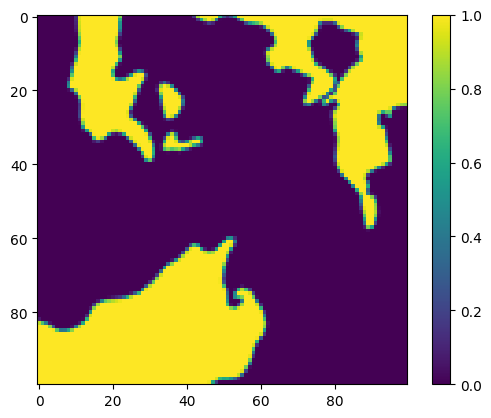

<Figure size 640x480 with 0 Axes>

In [5]:
band = RasterBand.from_map(
    experiment_map,
    location_types=LocationType.LAND,
    resolution=(100, 100),
)
plt.imshow(band.data)
plt.colorbar()
plt.show()
plt.clf()

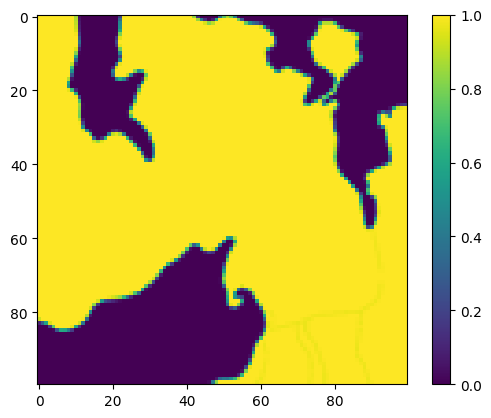

<Figure size 640x480 with 0 Axes>

In [6]:
band = RasterBand.from_map(
    experiment_map,
    location_types=LocationType.WATER,
    resolution=(100, 100),
)
plt.imshow(band.data)
plt.colorbar()
plt.show()
plt.clf()

## Now we integrate it into the a ProMis model

In [7]:
# Setup the engine
pmd = ProMis(
    origin=origin,
    dimensions=(1_000.0, 1_000.0),  # Meters
    resolution=(50, 50),  # Pixels
    location_types=[
        # Which types to load and compute relations for
        LocationType.LAND,
        LocationType.WATER,
    ],
    number_of_random_maps=10,  # How many maps to generate to compute statistics,
)
pmd.map = experiment_map
pmd.compute_distributions(None, cache=".promis_cache")

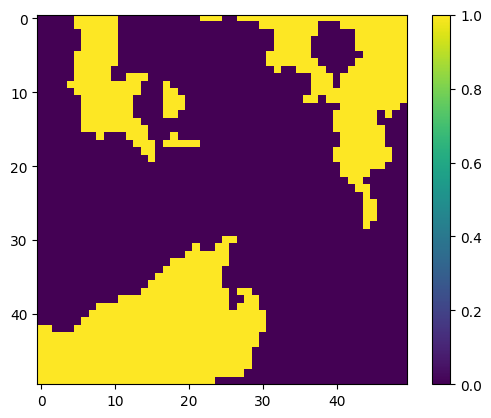

<Figure size 640x480 with 0 Axes>

In [8]:
plt.imshow(pmd.overs[LocationType.LAND].probability.data.T)
plt.colorbar()
plt.show()
plt.clf()

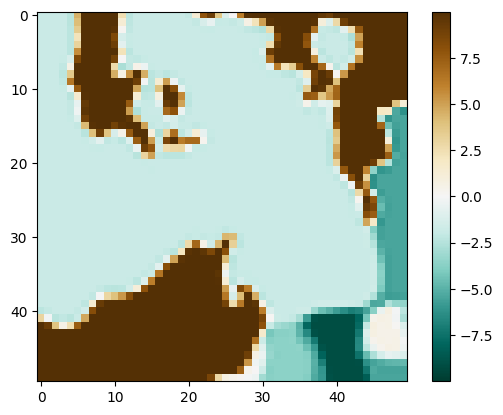

<Figure size 640x480 with 0 Axes>

In [9]:
plt.imshow(pmd.depth.mean.data.T, norm=CenteredNorm(), cmap="BrBG_r")
plt.colorbar()
plt.show()
plt.clf()

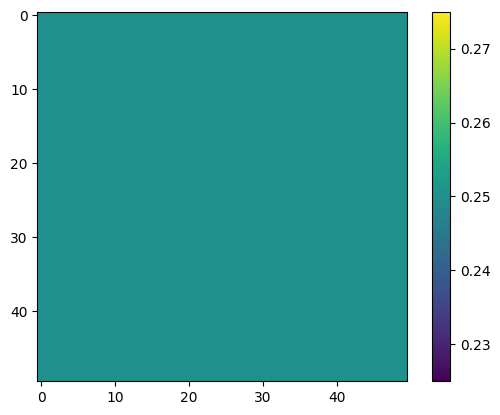

<Figure size 640x480 with 0 Axes>

In [10]:
plt.imshow(pmd.depth.variance.data)  # This is usually constant
plt.colorbar()
plt.show()
plt.clf()

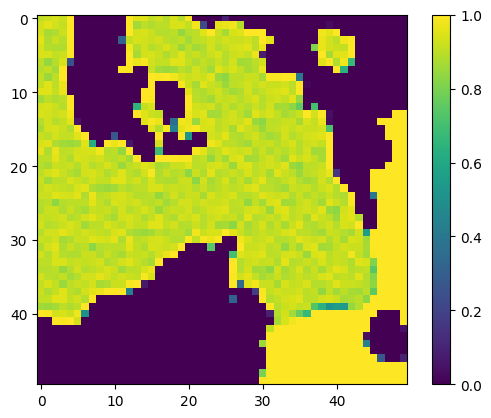

Time taken: 0.05s program, 0.01s compile, 4.41s inference
Mean: 0.58, Min: 0.00, Max: 1.00


<Figure size 640x480 with 0 Axes>

In [18]:
# Generate landscape
# with open("movement.pl") as model_file:
#     landscape, time = pmd.generate(logic=model_file.read(), n_jobs=8, batch_size=64)

model_code = """
landscape(R, C) :- depth(R, C) < -1.5.
"""
landscape, program_time, compile_time, inference_time = pmd.generate(
    logic=model_code, n_jobs=8, batch_size=64
)

# Show result
plt.imshow(landscape.data.T, vmin=0, vmax=1)
plt.colorbar()
plt.show()
plt.clf()

print(
    f"Time taken: {program_time:.2f}s program, {compile_time:.2f}s compile, {inference_time:.2f}s inference"
)
print(
    f"Mean: {landscape.data.mean():.2f}, Min: {landscape.data.min():.2f}, Max: {landscape.data.max():.2f}"
)